In [65]:
from pathlib import Path
import json
import pandas as pd

def _safe_float(x):
    try:
        return float(x)
    except (TypeError, ValueError):
        return None

def load_results(query_list, path_template):
    rows = []
    for q in query_list:
        p = Path(path_template.format(query=q))
        if not p.exists():
            print(f"[WARN] Missing file for {q}: {p}")
            continue
        with p.open('r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError as e:
                    print(f"[WARN] JSON error in {p}: {e}")
                    continue
                rows.append({
                    "query": q,
                    "iteration": obj.get("iteration"),
                    "selected_queries": obj.get("selected_queries"),
                    "mean_acc": obj.get("mean_acc"),
                    "mean_ppl": _safe_float(obj.get("mean_ppl")),
                })
    df = pd.DataFrame(rows)
    print(len(rows))
    # Normalize selected_queries and types
    if not df.empty:
        df["selected_queries"] = df["selected_queries"].apply(lambda s: None if s in (None, "None", "", "null") else str(s))
        df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce").astype("Int64")
        df["mean_acc"] = pd.to_numeric(df["mean_acc"], errors="coerce")
    return df.sort_values(["query", "iteration"])


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_per_iter_seaborn(per_iter_dict, metric="mean_acc", title=None, rolling=None, markers=False):
    """
    Plot multiple per-iteration curves (e.g., mean_acc or mean_ppl) using seaborn.
    
    Args:
        per_iter_dict: dict[str, pd.DataFrame]
            Mapping label -> DataFrame with columns ['iteration', metric].
        metric: str
            Column to plot, e.g., 'mean_acc' or 'mean_ppl'.
        title: str | None
            Optional title.
        rolling: int | None
            If set (e.g., 3), applies a centered rolling mean to smooth curves.
        markers: bool
            If True, add point markers.
    """
    if not per_iter_dict:
        raise ValueError("per_iter_dict is empty.")

    frames = []
    for label, df in per_iter_dict.items():
        if df is None or df.empty:
            print(f"[WARN] '{label}' is empty; skipping.")
            continue
        d = df.copy()
        d["iteration"] = pd.to_numeric(d["iteration"], errors="coerce")
        d = d.dropna(subset=["iteration"]).sort_values("iteration")
        d[metric] = pd.to_numeric(d[metric], errors="coerce")
        if rolling and isinstance(rolling, int) and rolling > 1:
            d[metric] = d[metric].rolling(rolling, center=True, min_periods=1).mean()
        d["run"] = label
        frames.append(d[["iteration", metric, "run"]])

    if not frames:
        raise ValueError("All inputs were empty after cleaning.")

    big = pd.concat(frames, ignore_index=True)

    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(
        data=big,
        x="iteration",
        y=metric,
        hue="run",
        marker="o" if markers else None,
        estimator=None,
    )
    ax.set_xlabel("Iteration")
    ax.set_ylabel(metric)
    # ax.set_ylim(0.2, 1.0)
    # ax.set_ylim(0.5, 8.0)

    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


36
36
36
36
36


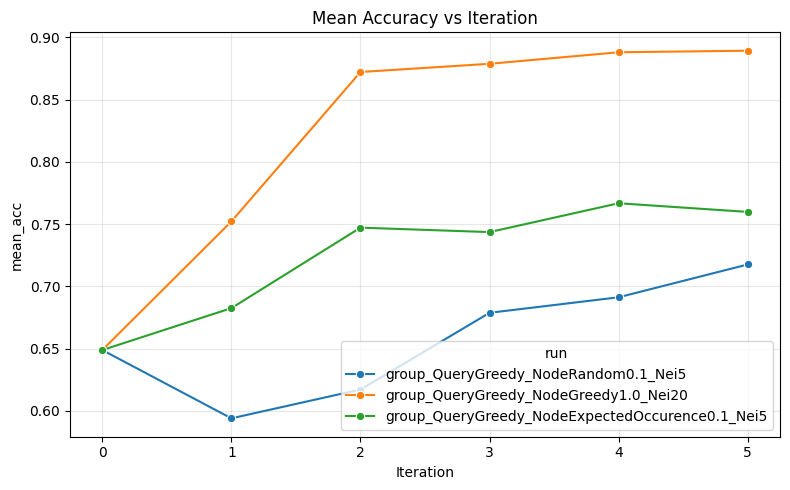

In [66]:
# query_list = ['333b', '355a', '330b', '334e', '331b', '331d', '334d', '327a', '330a', '334a']

# query_list = ['333b', '355a', '330b', '331d', '327a', '334a']

query_list = ['333b', '355a', '330b', '331d', '327a', '334a']

# random_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_tuning_demo/results_group_entropy/24_group_entropy_node_select_random_N30_percent0.1_T5_['{query}']_majority_top_k_nei5.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_tuning_demo/results_group_entropy/24_group_entropy_node_select_entropy_N5_percent0.1_T5_['{query}']_majority_top_k_nei20.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))


# greedy_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_tuning_demo/results_group_entropy/24_group_entropy_node_select_entropy_MIG_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_MIG_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))


# greedy_select_node_10_N_majority
path_tmpl = "/home/ruomeng/gae/results_tuning_demo/results_group_entropy/24_group_entropy_node_select_entropy_N30_percent1.0_T5_['{query}']_majority_top_k_nei20.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_10_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))



path_tmpl = "/home/ruomeng/gae/results_tuning_demo/results_group_entropy/24_group_entropy_node_select_occurence_out_N30_percent0.1_T5_['{query}']_majority_top_k_nei5.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
occor1 = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# ---------------------------
# Example:

plot_per_iter_seaborn(
    {"group_QueryGreedy_NodeRandom0.1_Nei5": random_select_node_01_N_majority, 
     "group_QueryGreedy_NodeGreedy1.0_Nei20": greedy_select_node_10_N_majority,
     "group_QueryGreedy_NodeExpectedOccurence0.1_Nei5": occor1,
},
    metric="mean_acc", title="Mean Accuracy vs Iteration", rolling=None, markers=True
)






In [67]:
random_select_node_01_N_majority

,iteration,mean_acc,mean_ppl
0,0,0.648860,3.324398
1,1,0.594017,4.451544
2,2,0.617165,4.015253
3,3,0.678775,3.004626
4,4,0.691239,2.711693
5,5,0.717593,2.603161


In [68]:
occor1

,iteration,mean_acc,mean_ppl
0,0,0.648860,3.324398
1,1,0.682514,3.132452
2,2,0.747151,2.382192
3,3,0.743590,2.424145
4,4,0.766738,2.173239
5,5,0.759793,2.225563
